# APS360 - Classifying Subreddits

Bassam Bibi<br>
Matthew Kwan

## Imports

In [1]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv('./data/updated_datav4.csv')
df.head()

,id,post,score,subreddit,title,url,subreddit_name
0,0,NaN,53782,0,"New ""Discovery Mode"" turns video game ""Assassi...",https://www.theverge.com/2018/2/20/17033024/as...,history
1,1,"Hi everyone and especially our students,\r\r\r...",38426,0,We are not here to help you with your End of T...,https://www.reddit.com/r/history/comments/8pw3...,history
2,2,NaN,35982,0,A 1776 excerpt from John Adam's diary where he...,https://founders.archives.gov/documents/Adams/...,history
3,3,NaN,34908,0,Famous Viking warrior burial revealed to be th...,http://www.news.com.au/technology/science/arch...,history
4,4,NaN,34197,0,"3,000-year-old underwater castle discovered in...",https://inhabitat.com/3000-year-old-underwater...,history


### Splitting Function for Punctuations

In [22]:
def split_post(post):
    # separate punctuations
    post = post.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ") \
                 .replace("\"", " \" ") \
                 .replace("!", " ! ") \
                 .replace(":", " : ")

    post = post.split() # Returns each word as an index in a list
    
    # Define remove list:
    rmv = ['that', 'what', 'at', 'just', 'you', 'up', 'in', 'and', 'my', 'for', 'from', 'how',
           'but', 'a', 'as', 'to', 'about', 'when', 'is', 'be', 'are', 'out', 'not', 'can', 'so',
           'this', 'do', 'it', 'an', 'like', 'would', 'time', 'with', 'if', 'know', 'of', 'I', 'the',
           'all', 'have', 'had', 'me', 'one', 'will', 'was', "I'm", 'them', 'they', 'there', 'on']
    
    post = [x for x in post if x not in rmv]
    
    return post

### Download GloVe Vectors

In [21]:
# Download pre-trained glove vectors

glove = torchtext.vocab.GloVe(name="6B", dim=100, max_vectors=10000) 

### Function the Split Data into Train, Test and Valid

In [23]:
def get_post_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(df.post):
        # If there is no text content in the post, then use the title of the post instead
            
        if line is np.nan:
            post = df.title[i]
        else:
            #  Truncate down to 300 characters
            post = line[:300]
           
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in split_post(post)
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore posts without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor
        label = torch.tensor(df.subreddit[i]).long() #IMPORTANT, need to convert this to numerical category
        if i % 5 < 3:
            train.append((idxs, label))
        elif i % 5 == 4:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
    return train, valid, test

train,valid,test = get_post_words(glove)

In [6]:
print("Train Length: {} Val Length: {} Test Length: {}".format(len(train),len(valid),len(test)))

Train Length: 7434 Val Length: 2488 Test Length: 2486


## Batching

In [8]:
import random

class PostBatcher:
    def __init__(self, posts, batch_size=32, drop_last=False):
        # store posts by length
        self.posts_by_length = {}
        for words, label in posts:
            # compute the length of the post
            wlen = words.shape[0]
            # put the posts in the correct key inside self.posts_by_length
            if wlen not in self.posts_by_length:
                self.posts_by_length[wlen] = []
            self.posts_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of posts of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    posts,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, posts in self.posts_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every post length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

With our batching function working, let's define our data loaders. Let's start with a batch-size of 16:

In [9]:
train_loader = PostBatcher(train,batch_size=128,drop_last=True)
valid_loader = PostBatcher(train,batch_size=128,drop_last=True)

In [10]:
for i, (posts, labels) in enumerate(train_loader):
    if i > 5: break
    print(posts.shape, labels.shape)

torch.Size([128, 27]) torch.Size([128])
torch.Size([128, 11]) torch.Size([128])
torch.Size([128, 8]) torch.Size([128])
torch.Size([128, 20]) torch.Size([128])
torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 5]) torch.Size([128])


In [12]:
train_loader

## Preliminary Model

In [11]:
class RedditLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=13):
        super(RedditLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=0.2)
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Apply dropout
        x = self.dropout(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(3, x.size(0), self.hidden_size)
        c0 = torch.zeros(3, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Training 

In [12]:
# Function to calculate the accuracy of the results. 
# Returns: # of Correct Predictions / Total # of Predictions

def get_accuracy(model, data_loader, find_loss=False):
  
    criterion = nn.CrossEntropyLoss()

    correct, total, loss = 0, 0, 0
    for posts, labels in data_loader:
        output = model(posts)
        if find_loss == True:
            loss = criterion(output,labels)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
   
    if find_loss == False:
        return correct / (total+0.0000001)
    else:
        return correct / (total+0.0000001),loss

In [27]:
def train_rnn_network(model, train, valid, batch_size=32, num_epochs=200, learning_rate=1e-4):
    
    criterion = nn.CrossEntropyLoss() # Need Cross Entropy for Multi-Classification
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = PostBatcher(train,batch_size=batch_size,drop_last=True)
    valid_loader = PostBatcher(valid,batch_size=batch_size,drop_last=True)
    
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    loss = 0
    epochs = []
    for epoch in range(num_epochs):
        for posts, labels in train_loader:
            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc,val_loss = get_accuracy(model, valid_loader, find_loss=True)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        if epoch %10 == 0:
            
            print("Epoch %d; Train Loss %f; Validation Loss %f; Train Acc %f; Val Acc %f" % ( \
                  epoch, loss, val_loss, train_acc[-1], valid_acc[-1]))
            
        # checkpoints
        if (epoch) % 5== 0:
            torch.save(model.state_dict(), "model_lr{}_epoch{}_bs{}_adam".format(learning_rate,epoch,batch_size))
    
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    return loss, val_loss, train_acc[-1], valid_acc[-1]

In [34]:
def train_rnn_network_rms(model, train, valid, batch_size=32, num_epochs=200, learning_rate=0.01):
    criterion = nn.CrossEntropyLoss() # Need Cross Entropy for Multi-Classification
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    train_loader = PostBatcher(train,batch_size=batch_size,drop_last=True)
    valid_loader = PostBatcher(valid,batch_size=batch_size,drop_last=True)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    loss = 0
    epochs = []
    for epoch in range(num_epochs):
        for posts, labels in train_loader:
            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc,val_loss = get_accuracy(model, valid_loader, find_loss=True)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        if epoch%10 == 0:
            print("Epoch %d; Train Loss %f; Validation Loss %f; Train Acc %f; Val Acc %f" % (
                  epoch, loss, val_loss, train_acc[-1], valid_acc[-1]))
        
        # checkpoints
        if (epoch) % 5== 0:
            torch.save(model.state_dict(), "model_lr{}_epoch{}_bs{}_rms".format(learning_rate,epoch,batch_size))
            
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    return loss, val_loss, train_acc[-1], valid_acc[-1]

In [35]:
def train_rnn_network_ada(model, train, valid, batch_size=32, num_epochs=200, learning_rate=0.01):
    criterion = nn.CrossEntropyLoss() # Need Cross Entropy for Multi-Classification
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
    train_loader = PostBatcher(train,batch_size=batch_size,drop_last=True)
    valid_loader = PostBatcher(valid,batch_size=batch_size,drop_last=True)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    loss = 0
    epochs = []
    
    for epoch in range(num_epochs):
        for posts, labels in train_loader:
            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc,val_loss = get_accuracy(model, valid_loader, find_loss=True)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        if epoch%10 == 0:
            print("Epoch %d; Train Loss %f; Validation Loss %f; Train Acc %f; Val Acc %f" % (
                  epoch, loss, val_loss, train_acc[-1], valid_acc[-1]))
        
        # checkpoints
        if (epoch) % 5== 0:
            torch.save(model.state_dict(), "model_lr{}_epoch{}_bs{}_ada".format(learning_rate,epoch,batch_size))
            
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    return loss, val_loss, train_acc[-1], valid_acc[-1]

## Random Search
A function to help with hyperparameter tuning.

In [47]:
def RandomSearch(n_iters, batch_sizes, learning_rates, hidden_sizes, opt="adam"):
    """
    n_iters: number of iterations to perform.
    batch_sizes: list of batch sizes.
    learning_rates: list of learning rates.
    hidden_sizes: list of hidden unit sizes.
    """
    list_data = []
    
    for i in range(n_iters):
        bs = np.random.randint(0,high=len(batch_sizes))
        lr = np.random.randint(0,high=len(learning_rates))
        hs = np.random.randint(0,high=len(hidden_sizes))
        
        model = RedditLSTM(100,hidden_sizes[hs])
        
        print("Batch Size: {} Learning Rate: {} Hidden Size: {}".format(batch_sizes[bs],learning_rates[lr],
                                                                        hidden_sizes[hs]))
        
        if opt == "ada":
            print("ada")
            result = train_rnn_network_ada(model,train,valid, learning_rate=learning_rates[lr], batch_size=batch_sizes[bs],
                                           num_epochs=30)
        elif opt == "RMS":
            print("RMS")
            result = train_rnn_network_rms(model,train,valid,learning_rate=learning_rates[lr],batch_size=batch_sizes[bs],num_epochs=50)
        else:
            result = train_rnn_network(model,train,valid,learning_rate=learning_rates[lr],batch_size=batch_sizes[bs],num_epochs=30)
        
        test_loader = PostBatcher(test,batch_size=batch_sizes[bs],drop_last=True)
        test_result = get_accuracy(model,test_loader)
        print("Test accuracy: {}".format(test_result))
        list_data.append([i,batch_sizes[bs],learning_rates[lr],hidden_sizes[hs],result[0],result[1],
                          result[2],result[3],test_result])
    
    
    
    
    df = pd.DataFrame(list_data,columns=["Iter", "batch size", "learning rate", "hidden size", "train loss",
                                         "valid loss","train acc", "valid acc","test_acc"])
    
    file_name = "randomsearch_"+opt+"2.csv"
    
    df.to_csv(file_name,index = False)

Batch Size: 16 Learning Rate: 0.005 Hidden Size: 64
RMS
Epoch 0; Train Loss 2.349422; Validation Loss 2.385110; Train Acc 0.184685; Val Acc 0.190741
Epoch 10; Train Loss 1.578683; Validation Loss 1.252971; Train Acc 0.692990; Val Acc 0.521759
Epoch 20; Train Loss 0.896749; Validation Loss 1.594567; Train Acc 0.780828; Val Acc 0.554630
Epoch 30; Train Loss 0.372766; Validation Loss 0.831496; Train Acc 0.827703; Val Acc 0.539815
Epoch 40; Train Loss 0.905976; Validation Loss 1.675381; Train Acc 0.839245; Val Acc 0.536111


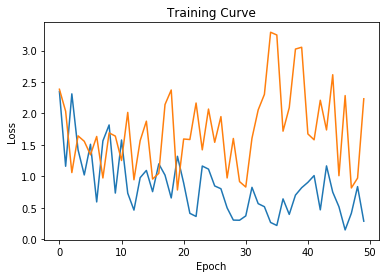

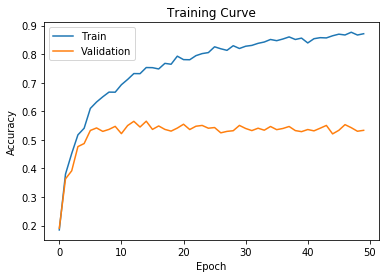

Test accuracy: 0.5192669172688315
Batch Size: 32 Learning Rate: 0.001 Hidden Size: 256
RMS
Epoch 0; Train Loss 1.995137; Validation Loss 1.912458; Train Acc 0.257405; Val Acc 0.234896
Epoch 10; Train Loss 0.754743; Validation Loss 1.070521; Train Acc 0.717565; Val Acc 0.585417
Epoch 20; Train Loss 0.235332; Validation Loss 1.695301; Train Acc 0.922690; Val Acc 0.564062
Epoch 30; Train Loss 0.068400; Validation Loss 2.411486; Train Acc 0.975711; Val Acc 0.579167
Epoch 40; Train Loss 0.188137; Validation Loss 1.804966; Train Acc 0.976600; Val Acc 0.564583


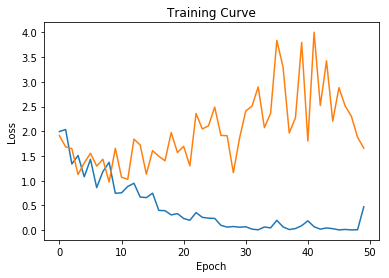

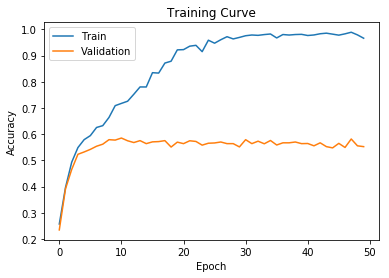

Test accuracy: 0.5394736841809499
Batch Size: 32 Learning Rate: 0.01 Hidden Size: 64
RMS
Epoch 0; Train Loss 2.402015; Validation Loss 2.506838; Train Acc 0.081309; Val Acc 0.079167
Epoch 10; Train Loss 0.964613; Validation Loss 1.449671; Train Acc 0.643957; Val Acc 0.550521
Epoch 20; Train Loss 0.818102; Validation Loss 1.865330; Train Acc 0.736226; Val Acc 0.552604
Epoch 30; Train Loss 0.899601; Validation Loss 1.617570; Train Acc 0.768661; Val Acc 0.546875
Epoch 40; Train Loss 0.609158; Validation Loss 1.838150; Train Acc 0.793691; Val Acc 0.551562


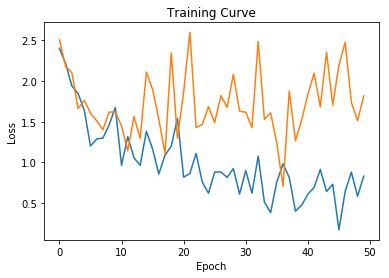

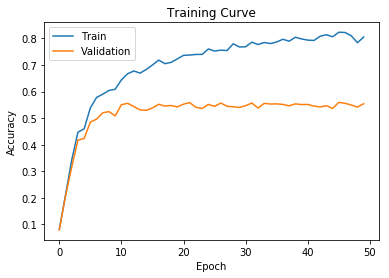

Test accuracy: 0.5301535087428644
Batch Size: 128 Learning Rate: 0.001 Hidden Size: 128
RMS
Epoch 0; Train Loss 2.365566; Validation Loss 0.000000; Train Acc 0.139391; Val Acc 0.000000
Epoch 10; Train Loss 1.473493; Validation Loss 0.000000; Train Acc 0.551604; Val Acc 0.000000
Epoch 20; Train Loss 1.155369; Validation Loss 0.000000; Train Acc 0.645148; Val Acc 0.000000
Epoch 30; Train Loss 0.945130; Validation Loss 0.000000; Train Acc 0.707854; Val Acc 0.000000
Epoch 40; Train Loss 0.649515; Validation Loss 0.000000; Train Acc 0.794408; Val Acc 0.000000


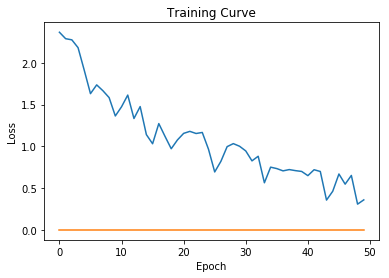

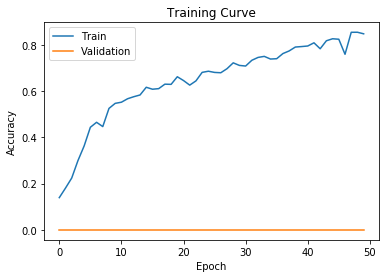

Test accuracy: 0.0
Batch Size: 16 Learning Rate: 0.005 Hidden Size: 32
RMS
Epoch 0; Train Loss 2.074570; Validation Loss 2.218791; Train Acc 0.255068; Val Acc 0.254630
Epoch 10; Train Loss 1.321053; Validation Loss 1.657416; Train Acc 0.641892; Val Acc 0.538426
Epoch 20; Train Loss 0.829994; Validation Loss 1.448979; Train Acc 0.714949; Val Acc 0.548611
Epoch 30; Train Loss 0.530845; Validation Loss 2.059063; Train Acc 0.745214; Val Acc 0.554630
Epoch 40; Train Loss 0.681058; Validation Loss 2.248999; Train Acc 0.766751; Val Acc 0.554167


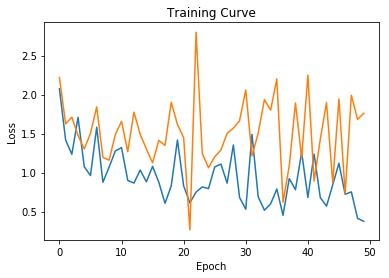

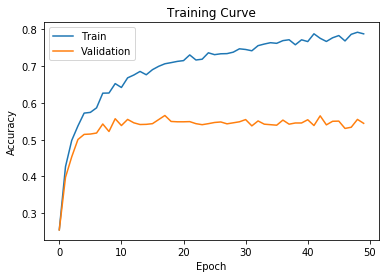

Test accuracy: 0.5300751879450153
Batch Size: 16 Learning Rate: 0.01 Hidden Size: 256
RMS
Epoch 0; Train Loss 2.529285; Validation Loss 2.403590; Train Acc 0.086852; Val Acc 0.084722
Epoch 10; Train Loss 1.553058; Validation Loss 1.641524; Train Acc 0.473677; Val Acc 0.433796
Epoch 20; Train Loss 1.434322; Validation Loss 1.045183; Train Acc 0.585023; Val Acc 0.521296
Epoch 30; Train Loss 1.230350; Validation Loss 1.200973; Train Acc 0.613035; Val Acc 0.542593
Epoch 40; Train Loss 0.951292; Validation Loss 1.737707; Train Acc 0.634431; Val Acc 0.531481


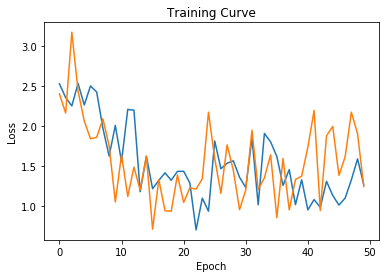

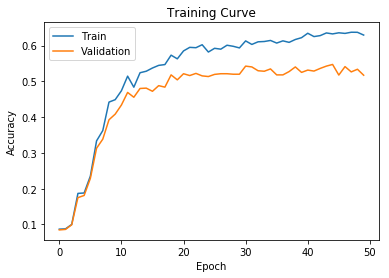

Test accuracy: 0.5178571428328075


In [48]:
batch_sizes = [8,16,32,64,128]
learning_rates = [0.01,0.005,0.001]
hidden_sizes = [32,64,128,256]

RandomSearch(6,batch_sizes,learning_rates,hidden_sizes,opt="RMS")

In [ ]:
-bs:8, lr:1e-05, hs:128
Epoch 0; Train Loss 2.542450; Validation Loss 2.514309; Train Acc 0.099684; Val Acc 0.105556

-bs:16, lr:5e-06, hs:64
Epoch 0; Train Loss 2.589120; Validation Loss 2.601496; Train Acc 0.065045; Val Acc 0.043883
Epoch 50; Train Loss 2.131216; Validation Loss 2.020390; Train Acc 0.180430; Val Acc 0.200798           

-bs:16, lr:0.0005, hs:128
Epoch 0; Train Loss 1.612568; Validation Loss 1.933496; Train Acc 0.219457; Val Acc 0.271277
Epoch 50; Train Loss 0.113162; Validation Loss 0.418212; Train Acc 0.964649; Val Acc 0.555851
